# Program Assignment #2 - 
# Decision Tree & Random Forest & KNN & PCA
---

## Name: 李勝維
## Student ID: 0711239

---

In [778]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Load data

In [779]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# load data
raw_data = pd.read_csv("data/student-mat.csv", sep=";").values

# # shuffle data
# np.random.shuffle(raw_data)

x, y = raw_data[..., :-1], raw_data[..., -1]
Categorical_Features = [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22]
Numerical_Features = [2, 6, 7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31]

# transform x to one-hot
x_encoder = OneHotEncoder(sparse=False)
x_cat = x_encoder.fit_transform(x[..., Categorical_Features])
x_num = x[..., Numerical_Features]
x = np.hstack((x_cat, x_num))

# transform y to binary / 5 class type
y_binary = np.digitize(y, [10]) # if G3 < 10, y = 0
y_5class = np.digitize(y, [21, 16, 14, 12, 10])
del y

# Principal components analysis
transforms training set and test set based on training set

In [780]:
from sklearn.decomposition import PCA
def pca_transform(train, test, k=10):
    pca = PCA(n_components=k)
    train = pca.fit_transform(train)
    test = pca.transform(test)
    return train, test

# Model Construction
### Algorithm behind decision tree:  
DecisionTreeClassifier from sklearn.tree uses CART (Classification and Regression Trees) algorithm, which is similar to C4.5 algorithm, but it supports numerical value (regression) and constructs binary trees using feature and its threshold which yields the largest information gain at each node.

### Difference between K-fold cross-validation and Random Forest:  


In [781]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
DTclf = DecisionTreeClassifier(random_state=0)
RF_nums = [4, 8, 16]
RFclfs = {k:RandomForestClassifier(random_state=0, n_estimators=k) for k in RF_nums}
KNN_nums = [8, 16, 32]
KNNclfs ={k:KNeighborsClassifier(n_neighbors=k) for k in KNN_nums}

# Validation
都是畫表格、算metrics的code，很醜不用看

In [782]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

def show_multiclass_score(y_pred, y_test, y_label, silent=False):
    # shows metrics for each class
    table_data = list()
    table_header = []
    accuracy = accuracy_score(y_test, y_pred)
    recalls = recall_score(y_test, y_pred, average=None)
    precisions = precision_score(y_test, y_pred, average=None)
    table_header = ['Metrics', 'Accuracy', 'Recall', 'Precision']
    for name, recall, precision in zip(y_label, recalls, precisions):
        table_data.append([name,accuracy, recall, precision])
    if not silent:
        print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro')



def compare_PCA(clf, class_type='binary'):
    ret = []
    # with PCA
    table_data = list()
    if class_type == 'binary':
        y = y_binary
        table_header = ['Confusion matrix', 'G3 < 10', 'G3 >= 10']
    else:
        y = y_5class
        table_header = ['Confusion matrix', 'I', 'II', 'III', 'IV', 'V']
    KF = KFold(n_splits=3)
    cat_pred = np.array([])
    cat_gt = np.array([])
    for train_idx, test_idx in KF.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        x_train, x_test = pca_transform(x_train, x_test)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
        cat_gt = np.concatenate([cat_gt, y_test], axis=0)
    y_pred = cat_pred
    y_test = cat_gt
    c_m = confusion_matrix(y_test, y_pred)/3
    for idx, row in enumerate(c_m):
        table_data.append([table_header[idx+1], *row])
    print("1. With PCA:")
    print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
    ret.append(show_multiclass_score(y_pred, y_test, table_header[1:]))

    # without PCA
    table_data = list()
    KF = KFold(n_splits=3)
    cat_pred = np.array([])
    cat_gt = np.array([])
    for train_idx, test_idx in KF.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
        cat_gt = np.concatenate([cat_gt, y_test], axis=0)
    y_pred = cat_pred
    y_test = cat_gt
    c_m = confusion_matrix(y_test, y_pred)/3
    for idx, row in enumerate(c_m):
        table_data.append([table_header[idx+1], *row])
    print("2. Without PCA:")
    print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
    ret.append(show_multiclass_score(y_pred, y_test, table_header[1:]))
    print()

    return ret

def compare_K(clf_dict, class_type='binary', silent=False):
    ret = list()
    for K, clf in clf_dict.items():
        table_data = list()
        if class_type == 'binary':
            y = y_binary
            table_header = ['Confusion matrix', 'G3 < 10', 'G3 >= 10']
        else:
            y = y_5class
            table_header = ['Confusion matrix', 'I', 'II', 'III', 'IV', 'V']
        KF = KFold(n_splits=3)
        cat_pred = np.array([])
        cat_gt = np.array([])
        for train_idx, test_idx in KF.split(x):
            x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
            cat_gt = np.concatenate([cat_gt, y_test], axis=0)
        y_pred = cat_pred
        y_test = cat_gt
        c_m = confusion_matrix(y_test, y_pred)/3
        for idx, row in enumerate(c_m):
            table_data.append([table_header[idx+1], *row])
        if not silent:
            print(f"For K = {K}:")
            print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
        ret.append(show_multiclass_score(y_pred, y_test, table_header[1:], silent=silent))
        if not silent:
            print()
    return ret
    

# Results Part 1: compare with and without PCA

In [783]:
# compare with / without PCA on three kinds of model on binary classification
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for DT
print("Result for DT comparing with and without PCA:")
rst = compare_PCA(DTclf, 'binary')
table_data.append(['DT with PCA', *rst[0]])
table_data.append(['DT without PCA', *rst[1]])
# for RF
print("Result for Random Forest comparing with and without PCA:")
rst = compare_PCA(RFclfs[RF_nums[len(RF_nums)//2]], 'binary')
table_data.append(['RF with PCA', *rst[0]])
table_data.append(['RF without PCA', *rst[1]])
# for KNN
print("Result for KNN comparing with and without PCA:")
rst = compare_PCA(KNNclfs[KNN_nums[len(KNN_nums)//2]], 'binary')
table_data.append(['KNN with PCA', *rst[0]])
table_data.append(['KNN without PCA', *rst[1]])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

# compare with / without PCA on three kinds of model on 5 class classification
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for DT
table_data = list()
print("Result for DT comparing with and without PCA:")
rst = compare_PCA(DTclf, '5-class')
table_data.append(['DT with PCA', *rst[0]])
table_data.append(['DT without PCA', *rst[1]])
# for RF
print("Result for Random Forest comparing with and without PCA:")
rst = compare_PCA(RFclfs[RF_nums[len(RF_nums)//2]], '5-class')
table_data.append(['RF with PCA', *rst[0]])
table_data.append(['RF without PCA', *rst[1]])
# for KNN
print("Result for KNN comparing with and without PCA:")
rst = compare_PCA(KNNclfs[KNN_nums[len(KNN_nums)//2]], '5-class')
table_data.append(['KNN with PCA', *rst[0]])
table_data.append(['KNN without PCA', *rst[1]])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for DT comparing with and without PCA:
1. With PCA:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   35.6667 │    7.66667 │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │   10      │   78.3333  │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.865823 │ 0.823077 │    0.781022 │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.865823 │ 0.886792 │    0.910853 │
╘═══════════╧════════════╧══════════╧═════════════╛
2. Without PCA:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═

# Results Part 2: compare different number of trees for random forest

In [784]:
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for random forest
print("Result for Random Forest comparing diffent tree number:")
rst = compare_K(RFclfs, 'binary')
for K, data in zip(RFclfs.keys(), rst):
    table_data.append([f'RF with {K} trees', *data])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

table_data = list()
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for random forest
print("Result for Random Forest comparing diffent tree number:")
rst = compare_K(RFclfs, 'binary')
for K, data in zip(RFclfs.keys(), rst):
    table_data.append([f'RF with {K} trees', *data])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for Random Forest comparing diffent tree number:
For K = 4:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   36.6667 │    6.66667 │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │   10.3333 │   78       │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.870886 │ 0.846154 │    0.780142 │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.870886 │ 0.883019 │    0.92126  │
╘═══════════╧════════════╧══════════╧═════════════╛

For K = 8:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞══════════════════

# Results Part 3: compare different K for KNN

In [785]:
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for KNN
print("Result for KNN comparing diffent K:")
rst = compare_K(KNNclfs, 'binary')
for K, data in zip(KNNclfs.keys(), rst):
    table_data.append([f'KNN with K = {K}', *data])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

table_data = list()
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for KNN
print("Result for KNN comparing diffent K:")
rst = compare_K(KNNclfs, 'binary')
for K, data in zip(KNNclfs.keys(), rst):
    table_data.append([f'KNN with K = {K}', *data])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for KNN comparing diffent K:
For K = 8:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   35.6667 │    7.66667 │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │    9      │   79.3333  │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.873418 │ 0.823077 │    0.798507 │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.873418 │ 0.898113 │    0.911877 │
╘═══════════╧════════════╧══════════╧═════════════╛

For K = 16:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════

# Comparison & Conclution
(DT代表decision tree, RF代表random forest, KNN代表KNN)
## 有無 PCA 的比較  
可以看到，RF和KNN兩種模型，在使用了經過PCA降維後的資料，其準確度會稍有提升，我想這是因為PCA將資料降維後，RF的可訓練參數（node）數量會大幅度的下降，因此避免了overfitting的困擾，而KNN要視資料分佈的domain來決定；而DT則是會稍有下降，或許是因為DT的可訓練參數量較少，無法享受到此福利，或者是在經過PCA降維後，因為隨機，導致建出來的樹形狀比較奇怪。  
## RF 中不同 tree 數目的比較
在4、8、16三種設定下，使用8棵樹可以達到最好的效能，我認為這也同樣受到了訓練資料量，和可訓練參數量之間平衡的影響。  
## KNN 中不同 K 數目的比較
我認為這個單純是 KNN 對於不同的資料分佈會有不同的K合適，因此做實驗時，使用elbow method來決定參數是很重要的！

# Questions
## Decision Tree
### Show the prediction and reasoning of one arbitrary sample in the testing set.
binary classification  
sample = [3.72523244, 2.2311476, 1.50909197, -2.224016, -1.53195296] (after PCA)  

![alt text](reasoning-decision-tree.png "Reasoning:")  

Thus, prediction = 1

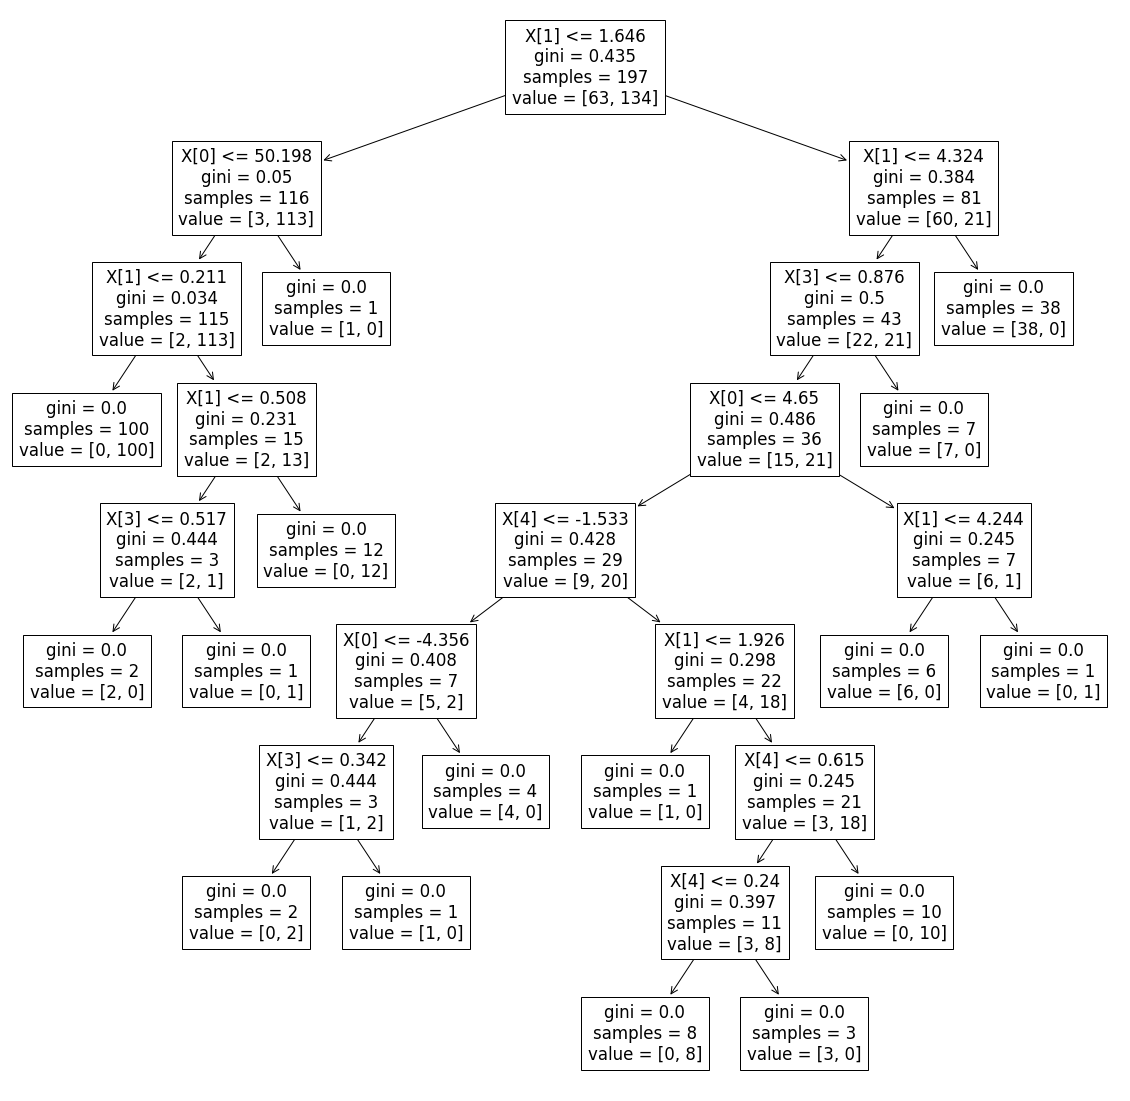

[ 3.72523244  2.2311476   1.50909197 -2.224016   -1.53195296] [1]


In [787]:
from sklearn import tree
# split data set
x_train, x_test = x[:x.shape[0]//2], x[x.shape[0]//2:]
y_train, y_test = y_binary[:y_binary.shape[0]//2], y_binary[y_binary.shape[0]//2:]
x_train, x_test = pca_transform(x_train, x_test, k=5)

# train a new model
DTclf = DecisionTreeClassifier(random_state=0)
DTclf.fit(x_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DTclf)
plt.show()

print(x_test[0], DTclf.predict(x_test[0, None]))

## Random Forest
### Describe the difference between boosting and bagging.  
Boosting: 雖然也是隨機選擇training data，但是會因為上一個classifier做錯而影響到每個sample的權重（做錯的，權重會上升），而之後的classifier會越來越專注於上一個classifier做錯的部分  
Bagging: 同時隨機的sample data，權重均相等，也就是說不同classifier之間是獨立的，其目的是為了降低整體的參數量。  
而 random forest 是屬於一種 bagging 的方法。